<a href="https://colab.research.google.com/github/KendallScott/Capstone/blob/main/Working%20RNN/Data_Cleanup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import pandas as pd

# Geospatial processing packages
import geopandas as gpd

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Loading dataframe on current active/and closed coal mines (provided by app voices)

In [ ]:
directory_path = '/content/drive/MyDrive/Mines_Data/'
directory_files = os.listdir(directory_path)

df = pd.DataFrame()
z=0
for i in directory_files:
    df_file = pd.read_csv(os.path.join(directory_path, i), encoding = 'ISO-8859-1',low_memory=False)
    df_file['year'] = directory_files[z]
    df_file['year'] = df_file['year'].str.slice(3, 7)
    df_file['end_date'] = df_file['year']+'-07-31'
    df_file['start_date'] = df_file['year']+'-07-01'
    df_file['start_date'] = pd.to_datetime(df_file['start_date'])
    df_file['end_date'] = pd.to_datetime(df_file['end_date'])

    df_file['State'] = directory_files[z]
    df_file['State'] = df_file['State'].str.slice(0, 2)

    df = pd.concat([df, df_file])

    z+=1


In [ ]:
all_year_mines = df['mine_id'][df['start_date']=='07-01-2023'].unique()
df = df.query('mine_id in @all_year_mines')

all_year_mines = df['mine_id'][df['year']=='2019'].unique()
df = df.query('mine_id in @all_year_mines')
group_df = df[['orig_perm_id', 'start_date', 'mine_id', 'Company', 'State', 'latitude', 'longitude']].groupby(['orig_perm_id', 'start_date', 'mine_id', 'State',  'latitude', 'longitude']).count().reset_index()
len(group_df)


525346

### aggregating to averages of land class(the probability) classes

In [ ]:
#mapping demo in python https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=SI5i7rboSGFL&uniqifier=2
# Read the downloaded file
#419bdf	water, #397d49	trees, #88b053	grass, #7a87c6	flooded_vegetation, #e49635	crops, #dfc35a	shrub_and_scrub, #c4281b	built, #a59b8f	bare, #b39fe1	snow_and_ice

label0 = df[['orig_perm_id', 'Company','mine_id','water', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id', 'start_date','Company']).mean().reset_index()
label1 = df[['orig_perm_id', 'Company','mine_id', 'trees', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id','start_date', 'Company']).mean().reset_index()
label2 = df[['orig_perm_id', 'Company','mine_id', 'grass', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id','start_date', 'Company']).mean().reset_index()
label3 = df[['orig_perm_id', 'Company','mine_id','flooded_vegetation', 'start_date', 'State']].groupby(['orig_perm_id', 'State','mine_id', 'start_date', 'Company']).mean().reset_index()
label4 = df[['orig_perm_id', 'Company','mine_id', 'crops', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index().drop_duplicates()
label5 = df[['orig_perm_id', 'Company','mine_id', 'shrub_and_scrub', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date', 'mine_id','Company']).mean().reset_index()
label6 = df[['orig_perm_id', 'Company','mine_id', 'built', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index()
label7 = df[['orig_perm_id', 'Company','mine_id', 'bare', 'start_date', 'State']].groupby(['orig_perm_id', 'State', 'start_date','mine_id', 'Company']).mean().reset_index()
label8 = df[['orig_perm_id', 'Company','mine_id', 'snow_and_ice', 'start_date', 'State']].groupby(['orig_perm_id', 'State','start_date','mine_id', 'Company']).mean().reset_index()

label0 =label0.drop_duplicates()
label1 =label1.drop_duplicates()
label2 =label2.drop_duplicates()
label3 =label3.drop_duplicates()
label4 =label4.drop_duplicates()
label5 =label5.drop_duplicates()
label6 =label6.drop_duplicates()
label7 =label7.drop_duplicates()
label8 =label8.drop_duplicates()

group_df = df[['orig_perm_id', 'start_date', 'mine_id', 'Company', 'State']].groupby(['orig_perm_id', 'start_date', 'mine_id', 'State']).count().reset_index()
group_df = group_df.drop_duplicates()
group_df = group_df.rename(columns={"Company": "Observations"})
df = pd.merge(df, group_df, on=['orig_perm_id', 'start_date', 'mine_id', 'State'], how='left').drop_duplicates()

df = df[['Company', 'start_date', 'Observations', 'orig_perm_id', 'mine_id', 'State']].drop_duplicates()
df = df.reset_index()
df = df.drop(['index'], axis=1)

### joining aggregated values back into main dataframe
df = pd.merge(df, label0, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label1, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label2, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label3, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label4, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label5, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label6, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label7, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()
df = pd.merge(df, label8, on=['orig_perm_id', 'start_date', 'Company', 'State', 'mine_id'], how='left').drop_duplicates()

df.fillna(0, inplace=True)
df

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice
0,B & C ENERGY INC,2023-07-01,45,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,0.065345,0.062902,0.035015,0.032943,0.036427
1,RIDNER COAL CO INC,2023-07-01,4,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,0.039489,0.036189,0.033532,0.034271,0.043253
2,HERBERT WELLS,2023-07-01,2,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,0.088415,0.041989,0.070858,0.030897,0.037347
3,MOUNT VICTORY COAL CO INC,2023-07-01,16,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,0.033263,0.031299,0.029638,0.032630,0.035219
4,EVERGREEN MINING INC,2023-07-01,30,8260501,0000000000000000086a,ky,0.030702,0.743186,0.033933,0.027343,0.029957,0.035815,0.029723,0.036228,0.032969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30473,LO-MING COAL CORP.,2017-07-01,1,U502397,0000000000000000085a,wv,0.031039,0.587889,0.039089,0.025979,0.048085,0.042070,0.107876,0.037235,0.042496
30474,"APPALACHIAN FUELS, LLC",2017-07-01,67,S304188,0000000000000000057b,wv,0.030835,0.739765,0.032717,0.027254,0.030536,0.037661,0.031239,0.037154,0.032554
30475,"CHICOPEE COAL COMPANY, INC.",2017-07-01,10,S007385,000000000000000007d5,wv,0.027965,0.710045,0.042984,0.025502,0.038912,0.048706,0.032311,0.033129,0.031919
30476,BELVA COAL COMPANY,2017-07-01,10,S009482,00000000000000000869,wv,0.036899,0.544176,0.040389,0.030385,0.046551,0.055853,0.064093,0.120093,0.039626


In [ ]:
len(df)

30478

## Created variables for mine_id and perm_id duplicates

In [ ]:
df[df['orig_perm_id'].isna()]

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice


In [ ]:
df[df['orig_perm_id']=='Z007881']

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice
26876,ELK RIVER SEWELL COAL COMPANY,2023-07-01,9,Z007881,000000000000000003e5,wv,0.023552,0.742361,0.034854,0.024266,0.034883,0.034910,0.032696,0.030865,0.037824
27809,ELK RIVER SEWELL COAL COMPANY,2021-07-01,12,Z007881,000000000000000003e5,wv,0.030378,0.741249,0.033265,0.028867,0.033076,0.030943,0.027757,0.035316,0.038792
29086,ELK RIVER SEWELL COAL COMPANY,2019-07-01,3,Z007881,000000000000000003e5,wv,0.020282,0.741894,0.038053,0.025082,0.038567,0.030875,0.032687,0.027879,0.041148


In [ ]:

company_df = df[['Company', 'mine_id']].groupby(['mine_id']).nunique().sort_values('mine_id', ascending=False).reset_index()
company_df = company_df.rename(columns={"Company": "Companies_per_mine_id"})
df = pd.merge(df, company_df, on=['mine_id'], how='left').drop_duplicates()
df

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,Companies_per_mine_id
0,B & C ENERGY INC,2023-07-01,45,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,0.065345,0.062902,0.035015,0.032943,0.036427,1
1,RIDNER COAL CO INC,2023-07-01,4,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,0.039489,0.036189,0.033532,0.034271,0.043253,1
2,HERBERT WELLS,2023-07-01,2,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,0.088415,0.041989,0.070858,0.030897,0.037347,1
3,MOUNT VICTORY COAL CO INC,2023-07-01,16,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,0.033263,0.031299,0.029638,0.032630,0.035219,1
4,EVERGREEN MINING INC,2023-07-01,30,8260501,0000000000000000086a,ky,0.030702,0.743186,0.033933,0.027343,0.029957,0.035815,0.029723,0.036228,0.032969,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30473,LO-MING COAL CORP.,2017-07-01,1,U502397,0000000000000000085a,wv,0.031039,0.587889,0.039089,0.025979,0.048085,0.042070,0.107876,0.037235,0.042496,2
30474,"APPALACHIAN FUELS, LLC",2017-07-01,67,S304188,0000000000000000057b,wv,0.030835,0.739765,0.032717,0.027254,0.030536,0.037661,0.031239,0.037154,0.032554,2
30475,"CHICOPEE COAL COMPANY, INC.",2017-07-01,10,S007385,000000000000000007d5,wv,0.027965,0.710045,0.042984,0.025502,0.038912,0.048706,0.032311,0.033129,0.031919,2
30476,BELVA COAL COMPANY,2017-07-01,10,S009482,00000000000000000869,wv,0.036899,0.544176,0.040389,0.030385,0.046551,0.055853,0.064093,0.120093,0.039626,2


In [ ]:

multistate_mine_id = df[['orig_perm_id', 'mine_id']].groupby(['mine_id']).nunique().sort_values('mine_id', ascending=False).reset_index()
multistate_mine_id = multistate_mine_id.rename(columns={"orig_perm_id": "multistate_mine_id"})
df = pd.merge(df, multistate_mine_id, on=['mine_id'], how='left').drop_duplicates()

permid_df = df[['orig_perm_id', 'mine_id']].groupby(['orig_perm_id']).nunique().sort_values('orig_perm_id', ascending=False).reset_index()
permid_df

permid_df = permid_df.rename(columns={"mine_id": "mines_per_perm_id"})
df = pd.merge(df, permid_df, on=['orig_perm_id'], how='left').drop_duplicates()
df

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,Companies_per_mine_id,multistate_mine_id,mines_per_perm_id
0,B & C ENERGY INC,2023-07-01,45,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,0.065345,0.062902,0.035015,0.032943,0.036427,1,1,1
1,RIDNER COAL CO INC,2023-07-01,4,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,0.039489,0.036189,0.033532,0.034271,0.043253,1,1,1
2,HERBERT WELLS,2023-07-01,2,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,0.088415,0.041989,0.070858,0.030897,0.037347,1,1,1
3,MOUNT VICTORY COAL CO INC,2023-07-01,16,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,0.033263,0.031299,0.029638,0.032630,0.035219,1,1,1
4,EVERGREEN MINING INC,2023-07-01,30,8260501,0000000000000000086a,ky,0.030702,0.743186,0.033933,0.027343,0.029957,0.035815,0.029723,0.036228,0.032969,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30473,LO-MING COAL CORP.,2017-07-01,1,U502397,0000000000000000085a,wv,0.031039,0.587889,0.039089,0.025979,0.048085,0.042070,0.107876,0.037235,0.042496,2,2,1
30474,"APPALACHIAN FUELS, LLC",2017-07-01,67,S304188,0000000000000000057b,wv,0.030835,0.739765,0.032717,0.027254,0.030536,0.037661,0.031239,0.037154,0.032554,2,2,1
30475,"CHICOPEE COAL COMPANY, INC.",2017-07-01,10,S007385,000000000000000007d5,wv,0.027965,0.710045,0.042984,0.025502,0.038912,0.048706,0.032311,0.033129,0.031919,2,2,1
30476,BELVA COAL COMPANY,2017-07-01,10,S009482,00000000000000000869,wv,0.036899,0.544176,0.040389,0.030385,0.046551,0.055853,0.064093,0.120093,0.039626,2,2,1


In [ ]:
#50 mines with numerous mine ids per orig_perm_id
9856-9906

-50

In [ ]:
df[['orig_perm_id', 'start_date', 'mine_id', 'Company', 'State']].groupby([ 'State']).count().reset_index()


,State,orig_perm_id,start_date,mine_id,Company
0,ky,26223,26223,26223,26223
1,tn,400,400,400,400
2,wv,3855,3855,3855,3855


### Creating empty rows for missing years

In [ ]:
df['key'] = df['mine_id']+df['State']
df[['key', 'start_date']].groupby(['key']).nunique().sort_values('key', ascending=False)

df[['key', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,key
start_date,
2023-07-01,9187
2021-07-01,9361
2019-07-01,9812
2017-07-01,2118


In [ ]:
date = ['2017-07-01', '2019-07-01', '2021-07-01']
df_clean = pd.DataFrame()
#imputation for missing years by permit_id

for x,i in enumerate(date):
  missing = df['key'][df['start_date']==date[x]].unique()
  df_clean_loop = df.loc[:, df.columns != 'start_date'].query('key not in @missing')

  df_clean_fill = df_clean_loop.groupby(['mine_id', 'orig_perm_id', 'Company', 'State', 'key']).mean().reset_index()
  df_clean_fill['start_date']=date[x]
  df_clean_fill['start_date'] = pd.to_datetime(df_clean_fill['start_date'])
  df_clean = df_clean.append(df_clean_fill)




<ipython-input-171-ddcb24a2927e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clean = df_clean.append(df_clean_fill)
<ipython-input-171-ddcb24a2927e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clean = df_clean.append(df_clean_fill)
<ipython-input-171-ddcb24a2927e>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_clean = df_clean.append(df_clean_fill)


In [ ]:
df['imputation']=0
df_clean['imputation']=1
df = df.append(df_clean)
df[['mine_id', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

### Removing any rows missing 2023

all_year_mines = df['mine_id'][df['start_date']=='07-01-2023'].unique()
df = df.query('mine_id in @all_year_mines')

<ipython-input-172-0f33bf262f76>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_clean)


In [ ]:
df['mine_id'].unique()

array(['00000000000000001112', '00000000000000001d20',
       '000000000000000020c7', ..., '000000000000000007d7',
       '0000000000000000095b', '0000000000000000031d'], dtype=object)

In [ ]:
date = ['2017-07-01', '2019-07-01', '2021-07-01', '2023-07-01']
df_clean = pd.DataFrame()
#imputation for missing years by permit_id

for x,i in enumerate(date):
  missing = df['mine_id'][df['start_date']==date[x]].unique()
  print('if zero, update succesful: ',len(df.query('key in @missing')))

if zero, update succesful:  0
if zero, update succesful:  0
if zero, update succesful:  0
if zero, update succesful:  0


In [ ]:
df[['mine_id', 'start_date']].groupby(['start_date']).nunique().sort_values('start_date', ascending=False)

,mine_id
start_date,
2023-07-01,8457
2021-07-01,8457
2019-07-01,8457
2017-07-01,8457


In [ ]:
len(df)

39307

In [ ]:
df[df['Companies_per_mine_id']==1]

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,crops,shrub_and_scrub,built,bare,snow_and_ice,Companies_per_mine_id,multistate_mine_id,mines_per_perm_id,key,imputation
0,B & C ENERGY INC,2023-07-01,45.0,8640180,00000000000000001112,ky,0.031113,0.623011,0.059563,0.032779,0.065345,0.062902,0.035015,0.032943,0.036427,1.0,1.0,1.0,00000000000000001112ky,0
1,RIDNER COAL CO INC,2023-07-01,4.0,9180010,00000000000000001d20,ky,0.031869,0.698788,0.039705,0.029274,0.039489,0.036189,0.033532,0.034271,0.043253,1.0,1.0,1.0,00000000000000001d20ky,0
2,HERBERT WELLS,2023-07-01,2.0,0320080,000000000000000020c7,ky,0.032205,0.539393,0.055222,0.030944,0.088415,0.041989,0.070858,0.030897,0.037347,1.0,1.0,1.0,000000000000000020c7ky,0
3,MOUNT VICTORY COAL CO INC,2023-07-01,16.0,404774X,00000000000000003095,ky,0.033029,0.735718,0.038324,0.029872,0.033263,0.031299,0.029638,0.032630,0.035219,1.0,1.0,1.0,00000000000000003095ky,0
6,BER COAL LLC,2023-07-01,6.0,8260670,000000000000000008bf,ky,0.032317,0.463962,0.098910,0.029844,0.068912,0.083604,0.054121,0.035295,0.036912,1.0,1.0,2.0,000000000000000008bfky,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,STUMP COAL COMPANY INC,2021-07-01,1.5,2985253,00000000000000002fbe,ky,0.027484,0.730087,0.032807,0.026845,0.036434,0.035243,0.031670,0.034360,0.040043,1.0,1.0,1.0,00000000000000002fbeky,1
675,ELKHORN EAGLE MINING COMPANY INC,2021-07-01,1.0,2985273,00000000000000002fca,ky,0.029705,0.730464,0.035289,0.027582,0.032840,0.038326,0.034288,0.037754,0.033707,1.0,1.0,1.0,00000000000000002fcaky,1
676,JEROLD AND JEFFREY COAL COMPANY INC,2021-07-01,1.5,2985288,00000000000000002fd2,ky,0.026915,0.738387,0.041519,0.026679,0.033050,0.036183,0.032921,0.030864,0.033014,1.0,1.0,1.0,00000000000000002fd2ky,1
677,LITTLE HACKNEY CREEK COAL CO,2021-07-01,1.5,2985319,00000000000000002fdc,ky,0.027767,0.748742,0.030551,0.028099,0.036952,0.026954,0.033159,0.029888,0.036835,1.0,1.0,1.0,00000000000000002fdcky,1


In [ ]:
tn = gpd.read_file('/content/drive/MyDrive/TN_Released_mines.geojson')
columns = ['id', 'national_i', 'Shape_Area', 'permit_a_2']
tn=tn[columns]
tn['State_alt']='tn'

wv = gpd.read_file('/content/drive/MyDrive/WV_Released_mines.geojson')
columns = ['id', 'ACRES_CURR', 'ACRES_DIST', 'ACRES_ORIG','ACRES_CURR', 'ACRES_RECL', 'EXPIRE_DAT', 'FACILITY_N', 'MAPTYPE', 'OPERATOR', 'PMLU2']
wv=wv[columns]
wv['State_alt']='wv'

In [ ]:
df_merge=df

In [ ]:
directory_path = '/content/drive/MyDrive/Mines_Data_Clean/Precipitation/'
directory_files = os.listdir(directory_path)

precip = pd.DataFrame()
z=0
for i in directory_files:
    df_file = pd.read_csv(os.path.join(directory_path, i), encoding = 'ISO-8859-1',low_memory=False)
    df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
    df_file['start_date_array'] = df_file['start_date_array'].str.slice(0, 13)
    df_file['start_date'] = pd.to_datetime(df_file['start_date_array'])

    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.split(" ", 1, expand=True)[1]
    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.slice(0, 13)
    df_file['orig_perm_id'] = df_file['orig_perm_id'].str.replace('\nNa', '')

    precip = pd.concat([precip, df_file])

    z+=1

<ipython-input-180-26c763670284>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
<ipython-input-180-26c763670284>:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['orig_perm_id'] = df_file['orig_perm_id'].str.split(" ", 1, expand=True)[1]
<ipython-input-180-26c763670284>:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['start_date_array'] = df_file['start_date_array'].str.split(" ", 1, expand=True)[1]
<ipython-input-180-26c763670284>:12: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_file['orig_perm_id'] = df_file['orig_pe

### Precipitation Data

In [ ]:
precip = precip.drop_duplicates()
precip = precip.drop(columns = 'start_date_array')
precip = precip[precip.columns[1:]]
keep_columns =['start_date', 'orig_perm_id', 'WaterQuality', 'Max Temperature', 'Precipitation']
precip = precip[keep_columns]

date = ['2017-07-01', '2019-07-01', '2021-07-01', '2023-07-01']
precip_clean = pd.DataFrame()
#imputation for missing years by permit_id
keep_columns =['orig_perm_id', 'WaterQuality', 'Max Temperature', 'Precipitation']

for x,i in enumerate(date):
  print(date[x])
  missing = precip['orig_perm_id'][precip['start_date']==date[x]]
  #finds permit_id that don't have a row for that year
  precip_clean_loop = precip[keep_columns].query('orig_perm_id not in @missing')

  precip_clean_fill = precip_clean_loop.groupby(['orig_perm_id']).mean().reset_index()
  precip_clean_fill['start_date'] = date[x]
  precip_clean_fill['start_date'] = pd.to_datetime(precip_clean_fill['start_date'])
  precip_clean = precip_clean.append(precip_clean_fill)
  missing = precip_clean['orig_perm_id'][precip_clean['start_date']==date[x]].unique()
  print('if zero, update succesful: ',len(precip_clean.query('orig_perm_id not in @missing')))

  precip_clean = precip_clean.append(precip)

precip_clean['orig_perm_id'] = precip_clean['orig_perm_id'].str.strip()
precip_clean = precip_clean.groupby(['orig_perm_id', 'start_date']).mean().reset_index()

<ipython-input-181-e90a658dad76>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip_clean_fill)
<ipython-input-181-e90a658dad76>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip)
<ipython-input-181-e90a658dad76>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip_clean_fill)
<ipython-input-181-e90a658dad76>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  precip_clean = precip_clean.append(precip)
<ipython-input-181-e90a658dad76>:21: FutureWarning: The frame.append method is deprecated and will be removed from pan

2017-07-01
if zero, update succesful:  0
2019-07-01
if zero, update succesful:  0
2021-07-01
if zero, update succesful:  0
2023-07-01
if zero, update succesful:  0


In [ ]:
precip_clean[precip_clean['orig_perm_id']=='8640180']

,orig_perm_id,start_date,WaterQuality,Max Temperature,Precipitation
23920,8640180,2017-07-01,-0.459511,299.720001,14.720000
23921,8640180,2019-07-01,-0.682684,304.200012,6.200000
23922,8640180,2021-07-01,-0.740470,295.899994,28.799999
23923,8640180,2023-07-01,0.044621,298.399994,3.600000


In [ ]:
len(df_merge)

39307

In [ ]:
df_merge_all = pd.merge(df_merge, precip_clean[['WaterQuality', 'orig_perm_id', 'start_date', 'Max Temperature', 'Precipitation']],  how='left', left_on=['orig_perm_id', 'start_date'], right_on = ['orig_perm_id', 'start_date'])
#downloaded this to excel and cleaned up the tennessee and west virginia data to get 1 model

In [6]:
df_merge_all = pd.read_csv('/content/mines_clean.csv', encoding = 'ISO-8859-1',low_memory=False)

In [7]:
df_merge_all[['Company', 'State','trees']].groupby(['Company', 'State']).mean().sort_values('trees', ascending=True)

,,trees
Company,State,
COLE BROS,ky,0.044158
"IKERD TERMINAL,",ky,0.055002
PRATER CONSTRUCTION,ky,0.062874
BOXLEY AGGREGATES OF WEST VIRGINIAL.L.C.,wv,0.063602
LAWRENCE LLOYD,ky,0.075644
...,...,...
AQUA PROCESSINGINC.,wv,0.757237
"HERNDON PROCESSING,",wv,0.757237
POCAHONTAS SALESINC.,wv,0.759869


In [8]:
df_merge_all[['mines_per_perm_id','trees']].groupby(['mines_per_perm_id']).mean().sort_values('trees', ascending=True)

,trees
mines_per_perm_id,
5,0.588976
6,0.595548
4,0.609252
3,0.634889
1,0.646179
2,0.651243


In [9]:
for i in df_merge_all.columns:
    if df_merge_all[i].isna().sum() > 0:
        print('{} has {}% NAs'.format(i,(df_merge_all[i].isna().sum() / len(df_merge_all))*100))

WaterQuality has 15.87757905716539% NAs
Max Temperature has 4.719261200295112% NAs
Precipitation has 9.089983972320452% NAs
QUAD_DESC has 15.918284275065512% NAs
Type_Flag has 15.8470501437403% NAs
PER_TYPE has 15.8470501437403% NAs
Source has 15.8470501437403% NAs
MINE_STATU has 15.8470501437403% NAs
FeatCLS has 15.8470501437403% NAs
REGION_DES has 15.8470501437403% NAs
Shape_Area has 98.67962449436487% NAs
ACRES_CURR has 85.47332536189482% NAs
ACRES_DIST has 85.47332536189482% NAs
ACRES_ORIG has 85.47332536189482% NAs
ACRES_CURR.1 has 85.47332536189482% NAs
ACRES_RECL has 92.37540387208385% NAs
EXPIRE_DAT has 85.47332536189482% NAs
FACILITY_N has 94.95000890426641% NAs
MAPTYPE has 85.66158699468288% NAs
coalmine_op_status has 30.745159895184067% NAs
inspectable_unit_status has 30.745159895184067% NAs
permit_approval_year has 52.93204772686799% NAs
OPERATOR has 94.34960694023965% NAs
PMLU2 has 98.468466176508% NAs
edit_date has 30.10405271325718% NAs
area_mine has 30.10405271325718% N

In [10]:
#Impute with mode for these columns
columns_to_impute_with_mode = ['Company','State',  'QUAD_DESC', 'Type_Flag', 'PER_TYPE', 'Source', 'MINE_STATU', 'FeatCLS', 'REGION_DES']

df_merge_all[columns_to_impute_with_mode] = df_merge_all[columns_to_impute_with_mode].fillna(df_merge_all[columns_to_impute_with_mode].mode().iloc[0])
nan_count = df_merge_all.isna().sum()
nan_count_sorted = nan_count.sort_values(ascending=False)
print(nan_count_sorted.head(12))

Shape_Area              38788
PMLU2                   38705
FACILITY_N              37322
OPERATOR                37086
ACRES_RECL              36310
MAPTYPE                 33671
ACRES_CURR              33597
ACRES_DIST              33597
ACRES_ORIG              33597
ACRES_CURR.1            33597
EXPIRE_DAT              33597
permit_approval_year    20806
dtype: int64


In [11]:
df_merge_all.columns

Index(['Company', 'start_date', 'Observations', 'orig_perm_id', 'mine_id',
       'State', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice',
       'Companies_per_mine_id', 'multistate_mine_id', 'mines_per_perm_id',
       'key', 'imputation', 'WaterQuality', 'Max Temperature', 'Precipitation',
       'QUAD_DESC', 'Type_Flag', 'PER_TYPE', 'Source', 'MINE_STATU', 'FeatCLS',
       'REGION_DES', 'Shape_Area', 'ACRES_CURR', 'ACRES_DIST', 'ACRES_ORIG',
       'ACRES_CURR.1', 'ACRES_RECL', 'EXPIRE_DAT', 'FACILITY_N', 'MAPTYPE',
       'coalmine_op_status', 'inspectable_unit_status', 'permit_approval_year',
       'OPERATOR', 'PMLU2', 'edit_date', 'area_mine', 'contour', 'mountaintop',
       'steep_slope', 'highwall', 'auger', 'contact'],
      dtype='object')

## Imputation with mode


In [12]:
df_merge_all[:1]

,Company,start_date,Observations,orig_perm_id,mine_id,State,water,trees,grass,flooded_vegetation,...,OPERATOR,PMLU2,edit_date,area_mine,contour,mountaintop,steep_slope,highwall,auger,contact
0,#8 LTD OF VIRGINIA,7/1/17,34.333333,8670027,0000000000000000125e,ky,0.031631,0.731359,0.034765,0.030271,...,NaN,NaN,2000.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0


In [13]:
df_merge_all.columns

Index(['Company', 'start_date', 'Observations', 'orig_perm_id', 'mine_id',
       'State', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice',
       'Companies_per_mine_id', 'multistate_mine_id', 'mines_per_perm_id',
       'key', 'imputation', 'WaterQuality', 'Max Temperature', 'Precipitation',
       'QUAD_DESC', 'Type_Flag', 'PER_TYPE', 'Source', 'MINE_STATU', 'FeatCLS',
       'REGION_DES', 'Shape_Area', 'ACRES_CURR', 'ACRES_DIST', 'ACRES_ORIG',
       'ACRES_CURR.1', 'ACRES_RECL', 'EXPIRE_DAT', 'FACILITY_N', 'MAPTYPE',
       'coalmine_op_status', 'inspectable_unit_status', 'permit_approval_year',
       'OPERATOR', 'PMLU2', 'edit_date', 'area_mine', 'contour', 'mountaintop',
       'steep_slope', 'highwall', 'auger', 'contact'],
      dtype='object')

In [14]:
df_merge_all['WaterQuality'] = df_merge_all['WaterQuality'].fillna(df_merge_all['WaterQuality'].mode().iloc[0])
df_merge_all['Precipitation'] = df_merge_all['Precipitation'].fillna(df_merge_all['Precipitation'].mode().iloc[0])
df_merge_all['Max Temperature'] = df_merge_all['Max Temperature'].fillna(df_merge_all['Max Temperature'].mode().iloc[0])

In [70]:
df_merge_all['years_to_expiration'] = df_merge_all['EXPIRE_DAT'] - df_merge_all['permit_approval_year']

In [71]:
from sklearn.preprocessing import MinMaxScaler

columns_to_encode = [ 'start_date', 'Company','State',  'QUAD_DESC', 'Type_Flag', 'PER_TYPE', 'Source', 'MINE_STATU', 'FeatCLS', 'REGION_DES']
#,'permit_application_year', 'imputation', 'permit_approval_year', 'permit_approval_month', 'edit_year', 'edit_month', 'permit_weekday',
all_mines_encoded = pd.get_dummies(df_merge_all[columns_to_encode], columns=columns_to_encode)

column_to_exclude = ['trees', 'water', 'snow_and_ice','grass','bare', 'built', 'shrub_and_scrub', 'crops', 'flooded_vegetation']

#one hot encoding categorical variables for model
cols = df_merge_all.columns
num_cols = df_merge_all._get_numeric_data().columns
num_cols =list(set(num_cols) - set(column_to_exclude))
num_cols =list(set(num_cols) - set(columns_to_encode))

#creating dataframe of numeric columns
scaler = MinMaxScaler(feature_range = (0, 1))
num_df = scaler.fit_transform(df_merge_all[num_cols])
num_df =pd.DataFrame(num_df,columns=df_merge_all[num_cols].columns, index=df_merge_all[num_cols].index)


all_mines_encoded = pd.merge(all_mines_encoded, num_df, left_index=True, right_index=True)
all_mines_encoded['trees'] = df_merge_all['trees']
#very quick imputation
all_mines_encoded = all_mines_encoded.fillna(0)

## Run to here for the RNN model, then skip the RF tables

In [72]:
all_mines_encoded = all_mines_encoded.drop(['FeatCLS_SF', 'QUAD_DESC_OLDTOWN', 'Company_ABBY', 'Company_ALEXANDRIA SALES CO LTD', 'Company_BRISBANE MINING', 'Company_BILLINGS CORP', 'Company_BLACKBERRY CREEK',
       'Company_BIG LOU CONSTRUCTION CO', 'Company_C & T CO',
       'Company_BIG RIDGE CO', 'Company_CALDWELL MNG', 'Company_BIG THREE CO',
       'Company_B P & S CO', 'Company_ARROW DEVELOPMENT', 'Company_BLUE JEL',
       'Company_BLUE RIDGE', 'Company_CAPRICORN', 'Company_C & H TRUCKING',
       'Company_BREATHITT COUNTY CO', 'Company_CAIN & SONS',
       'Company_BLANCH LEWIS', 'Company_BLACK DRAGON MINING',
       'Company_BLUE RESOURCES', 'Company_B & G MINING CO',
       'Company_APPLE TREE MINING CO', 'Company_BLACK MOUNTAIN',
       'Company_BEAVER ELKHORNINC.', 'Company_CARPER BROTHERS CO',
       'Company_BEDCORINC.', 'Company_B & C', 'Company_BENTCIL CO',
       'QUAD_DESC_BRUIN', 'Company_B & C CO', 'Company_C & N CO',
       'Company_A B C', 'Company_APPALACHAIN ENV TECH',
       'Company_AD HOLLI RESOURCES', 'Company_BILLY MORRIS',
       'Company_BALL BRANCH MINING', 'Company_CAROLYN MINING',
       'QUAD_DESC_BELFRY', 'Company_CAROL JOSEPH',
       'Company_B & H CONSTRUCTION', 'QUAD_DESC_ALCORN',
       'Company_BECKO CONST CO', 'Company_B J ENERGY CO',
       'Company_C. E. WEBB CONSTRUCTIONORPORATED',
       'Company_BUSTED STRAIGHT MINING CO',
       'Company_AMERICAN MINERALS CORPORATION', 'Company_C & C CONSTRUCTION', 'Company_A & V CORPORATION', 'Company_BLACK OAK',
       'Company_BITUMINOUS LAUREL MINING', 'Company_AL MINING',
       'Company_AM&EINCORPORATED', 'Company_C & C MINERALS',
       'Company_BIRCH CO', 'QUAD_DESC_NOT AVAILABLE', 'Company_AMBER MINING',
       'Company_BUCHANAN', 'QUAD_DESC_HYDEN WEST', 'Company_BROKEN HEART CORP',
       'Company_BLAKE CONSTRUCTION', 'Company_CASTLE CO',
       'QUAD_DESC_JELLICO EAST', 'Company_BRAXTON MINERALSINC.',
       'Company_BLUE MOON CO', 'Company_BOB FENTRESS',
       'Company_BUFORD T RUSSELL', 'Company_CAPERTON MINING',
       'Company_BLACKROCK', 'Company_BROWN & COLLINS CO', 'Company_CARLYNN',
       'Company_A B C DEVELOPING', 'Company_C H & S MINING CO',
       'Company_BEAVER CREEK COLLIERIES', 'QUAD_DESC_LIVINGSTON',
       'Company_BETTY ANN MINING', 'Company_BROKEN RIDGE',
       'Company_BLACK FIRE', 'Company_BLUE DIAMOND MINING',
       'Company_AMAH LAND', 'Company_BEBE CORPORATION', 'Company_C T L',
       'Company_C & J CO', 'Company_C & S FUEL',
       'Company_BOB & CECIL CONTRACTORS', 'Company_CAMBRIAN CORPORATION',
       'Company_BOONE ELKHORN MINING CO', 'Company_B & G SALES',
       'Company_ATHLETES FORGE INVESTMENTS', 'Company_BLAZER CORPORATION',
       'Company_BUFFALO CREEK MINERALS LTD', 'Company_BETA HYDROCARBONS',
       'Company_BONNIE SUE TACKETT', 'Company_APPALACHIAN COLLIERIES CORP',
       'Company_BEAVER MINERALS', 'Company_B & G CO', 'Company_B C CO',
       'Company_CAL-PACIFIC MINERALS', 'Company_BLACKWELL', 'Company_B C & B', 'Company_B & S CO',
       'Company_C & N MINING,', 'Company_CARR FORK DEVELOPMENT',
       'Company_BOORHEM & CAPPS CO', 'Company_CANBERRA RESOURCES',
       'Company_BAILEY HILL MINING', 'Company_ARTHUR FRANCIS', 'Company_AGE',
       'Company_B C B CO', 'Company_#8 LTD OF VIRGINIA',
       'Company_BLUE RIDGE ENTERPRISES', 'Company_BEAVER ELKHORN MINING',
       'Company_BEECH BRANCH CO', 'Company_CAVE RUN MINING CO',
       'Company_CAINS CREEK MINING CO', 'Company_BETTY WHITEHEAD',
       'QUAD_DESC_LEIGHTON', 'Company_4 R', 'Company_4 JINC.',
       'Company_BLUE BLAZE CO', 'Company_BLOCK', 'Company_BURNSIDE EXCAVATING',
       'Company_BLUE MOUNTAIN MININGINC', 'Company_BIG BRANCH LAND & MIN CO',
       'Company_BETTY JANE CO', 'Company_C & C',
       'Company_BOTTOMFORK DEVELOPMENT', 'Company_BLAINE CREEK MINING CO',
       'Company_BUD', 'Company_BLACKEY ELKHORN MNG', 'Company_ARN PHIL CO',
       'Company_BILLY FRANK CONSTRUCTION', 'Company_AUTHOR ENTERPRISESINC.',
       'Company_B B C CO', 'Company_ABCO MINING', 'Company_ARCHIE SIZEMORE',
       'Company_CAMP BRANCH ENERGY', 'QUAD_DESC_FOUNT', 'Company_ARIZONA CO',
       'Company_BEST ELKHORN MINING CO', 'Company_BIG DADDY MINING',
       'Company_BOBBY S YOUNG', 'Company_BUCK GARDENINC.',
       'Company_ALLEY BRANCH CO.', 'Company_CARBON GLO CO',
       'Company_CAROLINA MINING', 'Company_ARC KENTUCKY RESOURCES,',
       'Company_BIZZACK BROTHERS CONST CORP', ], axis=1)

In [73]:
#rf Test and Train dataset

columns = all_mines_encoded.columns
column_to_exclude = ['mine_name','permit_id','trees', 'water', 'snow_and_ice','grass','bare', 'flooded_vegetation', 'built', 'shrub_and_scrub', 'crops']
columns = list(set(columns) - set(column_to_exclude))
selected_columns = all_mines_encoded[columns].columns

sequence_length=4

features = all_mines_encoded[columns]
target = all_mines_encoded['trees']

from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

features['mine_id']=df_merge_all['mine_id']

X_trainrf, X_testrf, y_trainrf, y_testrf = train_test_split(features, target, test_size=0.3,  random_state=0, stratify=features['mine_id'])

In [74]:
X_trainrf = X_trainrf[selected_columns]
X_testrf = X_testrf[selected_columns]

In [75]:
rf = RandomForestRegressor(random_state=0,criterion='squared_error', n_estimators=150)

rf.fit(X_trainrf, y_trainrf)
rf_pred=rf.predict(X_testrf)

print('\nMean Squared Error (MSE):', mean_squared_error(y_testrf, rf_pred))
print('Mean Absolute Error (MAE):', mean_absolute_error(y_testrf, rf_pred))
print('R-squared (R^2):', r2_score(y_testrf, rf_pred))

In [76]:
rf.fit(X_trainrf, y_trainrf)

rf_pred=rf.predict(X_testrf)

mse = mean_squared_error(y_testrf, rf_pred)
mae = mean_absolute_error(y_testrf, rf_pred)
r2 = r2_score(y_testrf, rf_pred)

print('\nMean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('R-squared (R^2):', r2)


Mean Squared Error (MSE): 0.006581431810455862
Mean Absolute Error (MAE): 0.05197444387501822
R-squared (R^2): 0.6474721650394633


[Text(0.5, 1.0, 'Feature Importance from Random Forest')]

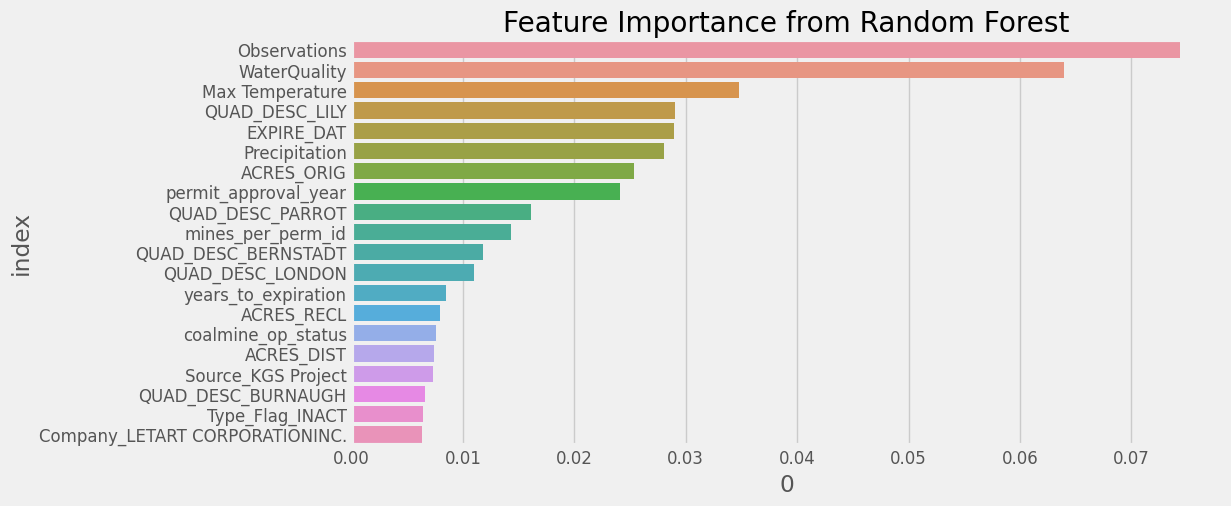

In [115]:
import seaborn as sns
import matplotlib.pyplot as plt


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12


feature_importance =rf.feature_importances_

forest_importances = pd.Series(feature_importance, index=selected_columns)
forest_importances = pd.DataFrame(forest_importances)

idx = forest_importances[0].sort_values(ascending = False).head(20).index
forest_importances2 = forest_importances.loc[idx]
data=forest_importances2.reset_index()

plt.style.use('tableau-colorblind10')
plt.figure(figsize = (10,5))
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels

sns.barplot(x=0, y='index', data=data).set(title='Feature Importance from Random Forest')

In [22]:
data

,index,0
0,Observations,0.074668
1,WaterQuality,0.063896
2,Max Temperature,0.034797
3,EXPIRE_DAT,0.029689
4,QUAD_DESC_LILY,0.029049
5,permit_approval_year,0.028824
6,Precipitation,0.028130
7,ACRES_ORIG,0.026069
8,QUAD_DESC_PARROT,0.016142
9,mines_per_perm_id,0.014230


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from keras.layers import LSTM
from keras.layers import Dropout

## Prepare RNN Dataset with sequences





In [24]:
test = all_mines_encoded[all_mines_encoded['start_date_7/1/23']==1]
train = all_mines_encoded[all_mines_encoded['start_date_7/1/23']==0]

In [109]:
columns = all_mines_encoded.columns
column_to_exclude = ['trees', 'water', 'snow_and_ice','grass','bare', 'flooded_vegetation', 'built', 'shrub_and_scrub', 'crops']
columns = list(set(columns) - set(column_to_exclude))
selected_columns = all_mines_encoded[columns].columns

sequence_length=4

features = all_mines_encoded[selected_columns]

target = all_mines_encoded['trees']
X, y, y_index = [], [], []
for i in range(len(features) - sequence_length):

   X.append(features.iloc[i:i + sequence_length].values)
   y.append(target.iloc[i + sequence_length])
   i=i+sequence_length

X=np.array(X)
y=np.array(y)

features['mine_id']=df_merge_all['mine_id']

for i in range(len(features) - sequence_length):
   y_index.append(features.mine_id.iloc[i + sequence_length])
   i=i+sequence_length

y_index=np.array(y_index)

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22,  random_state=0, stratify=y_index)

## RNN Model

In [82]:
pip install tensorboard

In [83]:
import tensorboard
import keras
from datetime import datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


In [84]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [111]:
from tensorflow.keras.callbacks import EarlyStopping
feature_length = X_train.shape[0]
#Li and L2 regularization
#from keras import optimizers

# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# fix random seed for reproducibility
tf.random.set_seed(42)

In [112]:
regressor = Sequential()
#regressor.add(tf.keras.layers.Masking(mask_value=0., input_shape=(sequence_length)))
regressor.add(LSTM(units = 50, input_shape=(sequence_length,
                   X_train.shape[2]),
                   return_sequences = True,
                   activation = 'relu'))

regressor.add(LSTM(units = 50, return_sequences = True, recurrent_dropout=0.80))
regressor.add(Dropout(0.15))
regressor.add(LSTM(50))
regressor.add(Dropout(0.15))
regressor.add(Dense(35))
regressor.add(Dropout(0.15))
regressor.add(Dense(1))

regressor.compile(optimizer = tf.keras.optimizers.Adam(), loss =tf.keras.losses.mean_squared_error)
es = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
regressor.fit(X_train, y_train, epochs=150, batch_size=32, validation_data= (X_test, y_test), callbacks=[es, tensorboard_callback])

y_pred = regressor.predict(X_test)

print('\nMean Squared Error (MSE):', mean_squared_error(y_test, y_pred))
print('Mean Absolute Error (MAE):', mean_absolute_error(y_test, y_pred))
print('R-squared (R^2):', r2_score(y_test, y_pred))

Epoch 1/150
958/958 [==============================] - 22s 17ms/step - loss: 0.0228 - val_loss: 0.0138
Epoch 2/150
958/958 [==============================] - 15s 16ms/step - loss: 0.0149 - val_loss: 0.0122
Epoch 3/150
958/958 [==============================] - 16s 17ms/step - loss: 0.0128 - val_loss: 0.0108
Epoch 4/150
958/958 [==============================] - 15s 16ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 5/150
958/958 [==============================] - 15s 15ms/step - loss: 0.0097 - val_loss: 0.0088
Epoch 6/150
958/958 [==============================] - 15s 16ms/step - loss: 0.0086 - val_loss: 0.0084
Epoch 7/150
958/958 [==============================] - 15s 16ms/step - loss: 0.0077 - val_loss: 0.0083
Epoch 8/150
958/958 [==============================] - 15s 16ms/step - loss: 0.0072 - val_loss: 0.0078
Epoch 9/150
958/958 [==============================] - 15s 15ms/step - loss: 0.0066 - val_loss: 0.0077
Epoch 10/150
958/958 [==============================] - 16s 16ms/step - l

In [114]:
regressor.save("name6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 75)             951600    
                                                                 
 lstm_1 (LSTM)               (None, 4, 75)             45300     
                                                                 
 lstm_2 (LSTM)               (None, 75)                45300     
                                                                 
 dropout (Dropout)           (None, 75)                0         
                                                                 
 dense (Dense)               (None, 1)                 76        
                                                                 
Total params: 1042276 (3.98 MB)
Trainable params: 1042276 (3.98 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


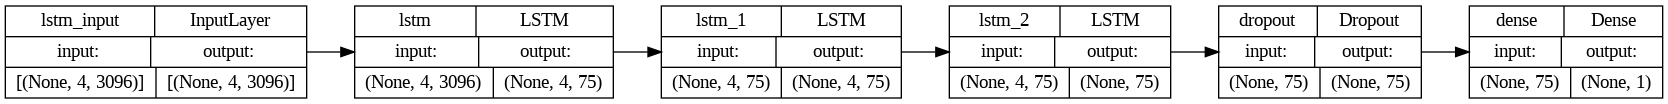

In [37]:

tf.keras.utils.plot_model(regressor, to_file='model.png', show_shapes=True, show_layer_names=True,rankdir='LR', expand_nested=True)

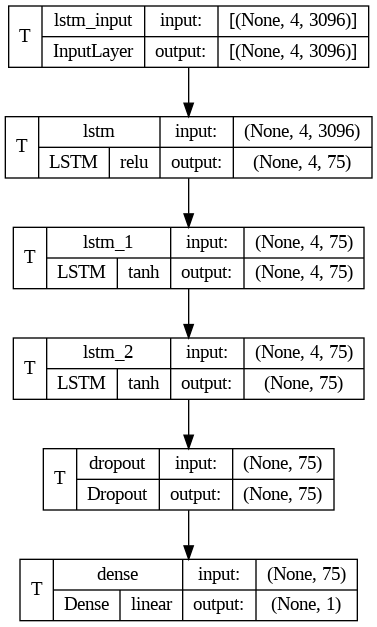

In [38]:
tf.keras.utils.plot_model(regressor, to_file='model.png',show_trainable=True, rankdir="TB",show_shapes=True, show_layer_activations=True)
